# Team Viviane Solomon and Brandon Bonifacio
# How We Split Up The Work: ...

# HW7: Train a Sequence Classifier That Can Predict if a Sentence is in English or Spanish.

The goal of this assignment is to train a sequence classifier that can predict if a sentence is in 
English or Spanish. You should use the official PyTorch documentation to build your system 
from scratch. You may use other online sources as well but must cite your sources and indicate 
clearly what portions of your code have been copied and modified from elsewhere. You may 
work individually or with a partner on this assignment.


Each team should submit one assignment as a single jupyter notebook on Sakai. At the top of 
your notebook, please indicate both team members’ names and who did what. To speed up 
training, you may want to run your jupyter notebook in Google Colab with a GPU. Note: The 
datasets provided below are very large, and you don’t need to train on everything!

In fact, as you develop your code, I would recommend using a tiny subset of data to iterate quickly, and 
wait until your code is debugged to start training on larger subsets of data. It is much better to 
have a functioning model that is trained on 1% of the data than a non-functional model that 
failed to train on 100% of the data.

An additional 10 points will be graded for the organization and clarity of your notebook. Your 
notebook should read like a tutorial and be understandable to others

## Part 1: Basic System with fixed-length inputs (65 points)

In the first part of the assignment you will do the following:


● Prepare the data (20 points). Get two large text files: one English file (WikiText-103, 
181MB) and one Spanish file (e.g. Spanish text corpus, 155MB). Convert to lowercase 
and remove all punctuation except “.” so the data only contains alphabet characters, 
whitespace, and periods. Determine a set of unique characters and map all characters 
to integers. Split the data into train & validation sets, and split each into chunks of fixed 
length.


● Train 1-layer model (20 Points). Define an LSTM model containing 1 LSTM layer 
followed by an output linear layer. Your model should classify a fixed-length sequence 
of characters as English or Spanish. Show your training & validation loss curves, along 
with your validation classification accuracy.


● Experimentation (20 points). Experiment with different aspects of the model: the 
number of LSTM layers, the number of fully connected layers, the size of the hidden 
layer, etc. Train the corresponding models, compare their performance, and provide 
plots to demonstrate the effect of at least two different hyperparameters of interest.


● Intuition (5 points). Show the output of your model for several specific sentences. Pick 
inputs that demonstrate the behavior of the system, and try to figure out what things 
the model is focusing on. Explain your intuition about what the model is doing

## Welcome to our Tutorial for Preparing the Data! 

### In the cell below, we go through the process of converting the text to lowercase and removing all punctuation except "." so the data only contains alphabet characters, whitespace, and periods for the Spanish Sentences. We also save this locally so we don't have to do this every time we load the file.

To provide an example for what we want to do with this data, we provide the first few sentences from the Spanish sentences.txt file. 

*la enciclopedia libre Jorge Hess De Wikipedia#

*la enciclopedia libre Saltar a Jorge Hess de julio es un y cofundador de la Liga Argentina de Esperanto Hess escribió un manual para el aprendizaje de esperanto que fue editado por primera vez en y se titula Sabe Usted Esperanto#

*Es uno de los más conocidos libros en español que tratan sobre el tema junto con Curso Práctico de Esperanto Ferenc Szilágyi#

*el cual Hess adaptó para los en#


## As you can see, each sentence begins with an aserisk (*), and it ends with a hashtag and a new-line character (#\n) After this function, these sentences in the txt file should look like: 

la enciclopedia libre jorge hess de wikipedia
la enciclopedia libre saltar a jorge hess de julio es un y cofundador de la liga argentina de esperanto hess escribió un manual para el aprendizaje de esperanto que fue editado por primera vez en y se titula sabe usted esperanto
es uno de los más conocidos libros en español que tratan sobre el tema junto con curso práctico de esperanto ferenc szilágyi
el cual hess adaptó para los en


(note that there is a newline between each sentence, but that Jupyter Notebook combines lines that only differ by one \n character)

In [7]:
#Import Statements
from tqdm import tqdm
import string
import torch
from torch.optim.lr_scheduler import StepLR
from torch import nn, optim

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader


In [8]:
## There is an important aspect of Spanish sentences we must consider. Python is mostly an English-based language, 
## so it is possible that Python might miss the diacriticed characters, namely é, á, í, ó, ú, ñ, and ü. However, 
## thankfully the Python devs have already thought of this, so we don't have to worry about it. However, we will continually
## check this throughout the process to make sure this is working as intended. 
## An example of Python functions working with Spanish characters is provided in the cell below. 

#Example of Python working with Spanish Characters - Python can work with Spanish!
espanol = "ÁÉÍÓÚÑÜ áéíóúñü."
print(espanol.lower())  
print(espanol.upper())

áéíóúñü áéíóúñü.
ÁÉÍÓÚÑÜ ÁÉÍÓÚÑÜ.


In [9]:
#Here, we make the process helper function to process a single sentence according to the problem
##Below, we convert the text in this file to lowercase, remove all punctuation except "."
def process(sentence):
    """
    Processes the given sentence string according to what the problem wants us to do:
    - Convert all characters to lowercase.
    - Remove all punctuation except ".". Keep whitespace characters ("\n" and " ", idk any others)
    """
    sentence = sentence.lower() #convert all characters to lowercase, O(n) time 
    
    #We are going to make a list of allowed characters! and if it's not in it, we get rid of it
    #the instructions say to keep only alphabetic characters, periods, and whitespaces, and that is what we will 
    #consist the allowed characters with
    
    #we are going to use a dictionary for O(1) lookup time
    allowed_characters = {
        " ": 0,
        "a": 1,
        "b": 2,
        "c": 3, 
        "d": 4,
        "e": 5, 
        "f": 6, 
        "g": 7, 
        "h": 8, 
        "i": 9, 
        "j": 10,
        "k": 11, 
        "l": 12,
        "m": 13, 
        "n": 14, 
        "o": 15,
        "p": 16,
        "q": 17, 
        "r": 18, 
        "s": 19, 
        "t": 20, 
        "u": 21, 
        "v": 22, 
        "w": 23, 
        "x": 24, 
        "y": 25, 
        "z": 26, 
        ".": 27, 
        "á": 28,
        "é": 29, 
        "í": 30,
        "ó": 31, 
        "ú": 32,
        "ñ": 33, 
        "ü": 34
        }
    
    processed_sentence = ''.join(char for char in sentence if char in allowed_characters)
    return processed_sentence

test_string = "Hi #%@ my 123415#$% name ..,3453,.,.343 !is B–RAND---ÓN B31onifacío. .@#$@$--=!~234324` . "
print(process(test_string))

hi  my  name .... is brandón bonifacío. . . 


In [10]:
## sentences.txt is our file of Spanish sentences. 
## With respect to this Jupyter Notebook's directory, this raw file is stored in (for Brandon's computer): 
## /Users\Brandon\Desktop\Classes\E208\Homework\E208HW7\Data\Raw\Spanish/sentences.txt

## After processing this data, we store it in 
## /E208/E208HW7/Data/Raw/Spanish/sentences.txt

## AS AN IMPORTANT NOTE, THIS CELL SHOULD ONLY BE RUN ONCE. 
## UNCOMMENT THE COMMAND AT THE BOTTOM TO RUN IT:
# Windows: Ctrl + / 
# Mac: Cmd + /

def process_spanish_information():
    # Path to the raw data
    input_path = "/Users\Brandon\Desktop\Classes\E208\Homework\E208HW7\Data\Raw\Spanish/sentences.txt"
    # Path to the processed data
    output_path = "/Users\Brandon\Desktop\Classes\E208\Homework\E208HW7\Data\Processed\Spanish/sentences.txt"

    #Open the input file and take out the sentences
    #https://stackoverflow.com/questions/2081836/how-to-read-specific-lines-from-a-file-by-line-number
    with open(input_path, "r") as file:
        raw_sentences = file.readlines()

    #Process each sentence
    processed_sentences = []
    for sentence in tqdm(raw_sentences, desc="Processing sentences"):
        if sentence.startswith('*') and sentence.endswith("#\n"): #Every sentence had a * in front of it and the end character at the end
            processed_sentences.append(process(sentence[1:-2]))
        else:
            print(f"Something went wrong! Here's the current sentence: {sentence}")
            raise

    #Now write the processed sentences to the output file
    with open(output_path, "w") as file:
        for sentence in tqdm(processed_sentences, desc="Writing to file"):
            if not "." in sentence: #Add this so that each sentence has a period at the end of it if it didnt already
                sentence += "."
            if not sentence.endswith("\n"):
                file.write(sentence + "\n") #Add new line whitespace at the end of each sentence
            else:
                file.write(sentence)
    return None


#Uncomment the line below to run this. 
#Note that this information is already saved in a txt file
#process_spanish_information()
print("Data processing complete!")

Data processing complete!


## Now that we have processed the Spanish sentences, we move on to processing the English sentences. However, the English sentences are in .tokens files, which we can open in VSCode. To provide an example of the text in the .tokens files, I provide the first few sentences from the file below: 


 = Robert Boulter = 
 
 Robert Boulter is an English film , television and theatre actor . He had a guest @-@ starring role on the television series The Bill in 2000 . This was followed by a starring role in the play Herons written by Simon Stephens , which was performed in 2001 at the Royal Court Theatre . He had a guest role in the television series Judge John Deed in 2002 . In 2004 Boulter landed a role as " Craig " in the episode " Teddy 's Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi . He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur , which was performed at the Drum Theatre in Plymouth and the <unk> Chocolate Factory in London . He was directed by John Tiffany and starred alongside Ben Whishaw , Shane Zaza , Harry Kent , Fraser Ayres , Sophie Stanton and Dominic Hall . 
 In 2006 , Boulter starred alongside Whishaw in the play Citizenship written by Mark Ravenhill . He appeared on a 2006 episode of the television series , Doctors , followed by a role in the 2007 theatre production of How to Curse directed by Josie Rourke . How to Curse was performed at Bush Theatre in the London Borough of Hammersmith and Fulham . Boulter starred in two films in 2008 , Daylight Robbery by filmmaker Paris <unk> , and Donkey Punch directed by Olly Blackburn . In May 2008 , Boulter made a guest appearance on a two @-@ part episode arc of the television series Waking the Dead , followed by an appearance on the television series Survivors in November 2008 . He had a recurring role in ten episodes of the television series Casualty in 2010 , as " Kieron Fletcher " . Boulter starred in the 2011 film Mercenaries directed by Paris <unk> . 
 
 = = Career = = 
 
 
 = = = 2000 – 2005 = = = 
 
 In 2000 Boulter had a guest @-@ starring role on the television series The Bill ; he portrayed " Scott Parry " in the episode , " In Safe Hands " . Boulter starred as " Scott " in the play Herons written by Simon Stephens , which was performed in 2001 at the Royal Court Theatre . A review of Boulter 's performance in The Independent on Sunday described him as " horribly menacing " in the role , and he received critical reviews in The Herald , and Evening Standard . He appeared in the television series Judge John Deed in 2002 as " <unk> Armitage " in the episode " Political <unk> " , and had a role as a different character " Toby Steele " on The Bill . 
 He had a recurring role in 2003 on two episodes of The Bill , as character " Connor Price " . In 2004 Boulter landed a role as " Craig " in the episode " Teddy 's Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi . Boulter starred as " Darren " , in the 2005 theatre productions of the Philip Ridley play Mercury Fur . It was performed at the Drum Theatre in Plymouth , and the <unk> Chocolate Factory in London . He was directed by John Tiffany and starred alongside Ben Whishaw , Shane Zaza , Harry Kent , Fraser Ayres , Sophie Stanton and Dominic Hall . Boulter received a favorable review in The Daily Telegraph : " The acting is shatteringly intense , with wired performances from Ben Whishaw ( now unrecognisable from his performance as Trevor Nunn 's Hamlet ) , Robert Boulter , Shane Zaza and Fraser Ayres . " The Guardian noted , " Ben Whishaw and Robert Boulter offer tenderness amid the savagery . " 
 
 = = = 2006 – present = = =

## As you can see, the formatting is a bit more complex than before. After processing, in order to format it in the same way as the spanish sentences, we want the post-processed sentences to look like this: 

 robert boulter is an english film  television and theatre actor .
he had a guest  starring role on the television series the bill in 2000 .
this was followed by a starring role in the play herons written by simon stephens  which was performed in 2001 at the royal court theatre .
he had a guest role in the television series judge john deed in 2002 .
in 2004 boulter landed a role as  craig  in the episode  teddy s story  of the television series the long firm  he starred alongside actors mark strong and derek jacobi .
he was cast in the 2005 theatre productions of the philip ridley play mercury fur  which was performed at the drum theatre in plymouth and the unk chocolate factory in london .
he was directed by john tiffany and starred alongside ben whishaw  shane zaza  harry kent  fraser ayres  sophie stanton and dominic hall .
 in 2006  boulter starred alongside whishaw in the play citizenship written by mark ravenhill .
he appeared on a 2006 episode of the television series  doctors  followed by a role in the 2007 theatre production of how to curse directed by josie rourke .
how to curse was performed at bush theatre in the london borough of hammersmith and fulham .
boulter starred in two films in 2008  daylight robbery by filmmaker paris unk  and donkey punch directed by olly blackburn .
in may 2008  boulter made a guest appearance on a two  part episode arc of the television series waking the dead  followed by an appearance on the television series survivors in november 2008 .
he had a recurring role in ten episodes of the television series casualty in 2010  as  kieron fletcher  .
boulter starred in the 2011 film mercenaries directed by paris unk .
 in 2000 boulter had a guest  starring role on the television series the bill  he portrayed  scott parry  in the episode   in safe hands  .
boulter starred as  scott  in the play herons written by simon stephens  which was performed in 2001 at the royal court theatre .
a review of boulter s performance in the independent on sunday described him as  horribly menacing  in the role  and he received critical reviews in the herald  and evening standard .
he appeared in the television series judge john deed in 2002 as  unk armitage  in the episode  political unk   and had a role as a different character  toby steele  on the bill .
 he had a recurring role in 2003 on two episodes of the bill  as character  connor price  .
in 2004 boulter landed a role as  craig  in the episode  teddy s story  of the television series the long firm  he starred alongside actors mark strong and derek jacobi .
boulter starred as  darren   in the 2005 theatre productions of the philip ridley play mercury fur .
it was performed at the drum theatre in plymouth  and the unk chocolate factory in london .
he was directed by john tiffany and starred alongside ben whishaw  shane zaza  harry kent  fraser ayres  sophie stanton and dominic hall .
boulter received a favorable review in the daily telegraph   the acting is shatteringly intense  with wired performances from ben whishaw  now unrecognisable from his performance as trevor nunn s hamlet   robert boulter  shane zaza and fraser ayres .
 the guardian noted   ben whishaw and robert boulter offer tenderness amid the savagery .

## To format this, we're going to follow the same approach as with the Spanish sentences, except we're going to take extra steps to get rid of inconsistent spacing or sentences that begin with a "=" because these aren't sentences. We need to take this extra step because the english sentences are plagued with inconsistent formats like these. 

In [11]:
##Note: This should only be run once, so uncomment the command at the bottom when we need to make a new sentences.txt file


def process_english_sentences():

    # Path to the raw data
    input_path = "/Users\Brandon\Desktop\Classes\E208\Homework\E208HW7\Data\Raw\English/"
    # And the files we gotta process:
    files = ["wiki.test.tokens", "wiki.train.tokens", "wiki.valid.tokens"]
    # Path to the processed data
    output_path = "/Users\Brandon\Desktop\Classes\E208\Homework\E208HW7\Data\Processed\English/sentences.txt"

    #Open the input file and take out the sentences
    #https://stackoverflow.com/questions/2081836/how-to-read-specific-lines-from-a-file-by-line-number
    raw_sentences = []
    #Add the lines through each file to a single list
    for file in files:
        #As a note, we have to use utf-8 here because it works better than regular open:
        #https://stackoverflow.com/questions/36303919/what-encoding-does-open-use-by-default
        with open(input_path +file, "r", encoding='utf-8') as reading_file:
            sentences = reading_file.readlines() #initially split it by lines, this will allow us to skip "=" lines
            for sentence in tqdm(sentences, desc="Going through sentences for " + file): #go through each sentence
                if len(sentence) > 3: #only keep sentences that aren't newlines and are actually sentences
                    if sentence[0] != "=" and sentence[0:2] != " =": #We don't want to keep the "=" lines
                        real_sentences = sentence.split(". ") #Once we have the sentences now, split by periods
                        for real_sentence in real_sentences: #Go through each sentence we have now
                            real_sentence = real_sentence.replace("<unk>", "") #remove this annoying string that's EVERYWHERE in the data
                            real_sentence = real_sentence.replace("  ", " ") #replace double spaces
                            real_sentence = real_sentence.replace(" .", ".") #get rid of spaces before periods
                            raw_sentences.append(real_sentence + ".") #add the period back


    #Process each sentence
    processed_sentences = []
    for sentence in tqdm(raw_sentences, desc="Processing sentences"):
        if len(sentence) > 1: #We only want nonzero sentences
            if sentence[0:2] != " =": #We don't want the sentences that start with an " =" as shown above
                processed_sentence = process(sentence)
                if len(processed_sentence) > 5: #5 is the shortest sentence possible in English with periods and spaces
                    #We needed to do the extra check to make sure its nonzero after processing because processing removes
                    #characters
                    processed_sentences.append(processed_sentence)

    #Now write the processed sentences to the output file
    with open(output_path, "w", encoding = 'utf-8') as file:
        for sentence in tqdm(processed_sentences, desc="Writing to file"):
            file.write(sentence + "\n") #Add new line whitespace at the end of each sentence, in same structure as espanol

    return None

#Uncomment this to make the txt file
#process_english_sentences()

print("Data processing complete!")

Data processing complete!


## Now that we have processed the data as required by the problem, we now determine a set of unique characters and map all characters to integers. Because the problem stated that each sentence should only consist of alphabet characters, whitespace, and periods, we only include these in the unique character map. We also don't include the newline whitespace character because, as per the way we designed the sentences to be separated, the newline character is only used to separate the sentences in the txt files. 


## Then, we make the training and validation sets. For now, we'll only analyze 0.1% of the data until we get a full model working.

In [12]:
unique_character_map = {
    " ": 0,
    "a": 1,
    "b": 2,
    "c": 3, 
    "d": 4,
    "e": 5, 
    "f": 6, 
    "g": 7, 
    "h": 8, 
    "i": 9, 
    "j": 10,
    "k": 11, 
    "l": 12,
    "m": 13, 
    "n": 14, 
    "o": 15,
    "p": 16,
    "q": 17, 
    "r": 18, 
    "s": 19, 
    "t": 20, 
    "u": 21, 
    "v": 22, 
    "w": 23, 
    "x": 24, 
    "y": 25, 
    "z": 26, 
    ".": 27, 
    "á": 28,
    "é": 29, 
    "í": 30,
    "ó": 31, 
    "ú": 32,
    "ñ": 33, 
    "ü": 34
}

#We make a helper function to convert a sentence to a fixed length and also map it to the integer map
def convert_sentence_to_fixed_length(sentence, length=100):
    # Convert each character to its integer representation
    sequence = [unique_character_map[char] for char in sentence if char in unique_character_map]
    # If shorter than required length, pad with zeros
    while len(sequence) < length:
        sequence.append(0)
    # If longer, trim it
    return sequence[:length]
print(convert_sentence_to_fixed_length("perry the platapus. quero ir al bano"))

[16, 5, 18, 18, 25, 0, 20, 8, 5, 0, 16, 12, 1, 20, 1, 16, 21, 19, 27, 0, 17, 21, 5, 18, 15, 0, 9, 18, 0, 1, 12, 0, 2, 1, 14, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [13]:
def get_train_val_loaders(dataset_proportion = 0.001, val_split = 0.3, batch_size=1024, num_workers=0):
    """
    This helper function will create our Validation and Training loaders as 
    specified in problem 1. 
    
    """

    #Data/EnglishSentences.txt
    english_file = "Data/EnglishSentences.txt"
    #english_file = "/Users\Brandon\Desktop\Classes\E208\Homework\E208HW7\Data\Processed\English/sentences.txt"
    #spanish_file = "/Users\Brandon\Desktop\Classes\E208\Homework\E208HW7\Data\Processed\Spanish/sentences.txt"
    spanish_file = "Data/ProcessedSpanishSentences.txt"
    
    print("Reading the files.")
    with open(english_file, 'r', encoding='utf-8') as file:
        english_sentences = file.readlines()

    with open(spanish_file, 'r') as file:
        spanish_sentences = file.readlines()

    #Specify how much of the data we're using
    english_subset_size = int(dataset_proportion * len(english_sentences))
    spanish_subset_size = int(dataset_proportion * len(spanish_sentences))

    english_subset = english_sentences[:english_subset_size]
    spanish_subset = spanish_sentences[:spanish_subset_size]

    # Split the subset into training (70%) and validation (30%) sets
    english_train_size = int(0.7 * english_subset_size)
    spanish_train_size = int(0.7 * spanish_subset_size)

    train_sentences = english_subset[:english_train_size] + spanish_subset[:spanish_train_size]
    train_labels = [0] * english_train_size + [1] * spanish_train_size

    validation_sentences = english_subset[english_train_size:] + spanish_subset[spanish_train_size:]
    validation_labels = [0] * (english_subset_size - english_train_size) + [1] * (spanish_subset_size - spanish_train_size)

    train_data = [convert_sentence_to_fixed_length(sentence) for sentence in tqdm(train_sentences, "Training")]
    validation_data = [convert_sentence_to_fixed_length(sentence) for sentence in tqdm(validation_sentences, "Validation")]
    
    
    #Now that we have lists of our training and validation data, we will convert them to the super useful 
    #DataLoader class from Pytorch that allows us to use batch training and makes our life easier. 
    
    #HOW TO MAKE OUR TRAIN_DATASET (primary resource used):
    #https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?ref=mlnuggets.digitalpress.blog
                          
    #In order to make train_dataset and val_dataset, we need to make objects that have specific properties that 
    #PyTorch is looking for, i.e.: 
    class CustomDataset(Dataset):
        def __init__(self, sentences, labels):
            #Need to put everything in tensors so we can put it on a gpu later
            self.sentences = torch.tensor(sentences)
            self.labels = torch.tensor(labels)

        def __len__(self):
            return len(self.sentences)

        def __getitem__(self, index):
            #here we return the sentence and whether it is English or Espanol
            return self.sentences[index], self.labels[index]               
    
    #now we can make our custom data object for the DataLoader
    train_dataset = CustomDataset(train_data, train_labels)
    val_dataset = CustomDataset(validation_data, validation_labels)
    
    #copy over from HW6
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    
    return train_loader, val_loader


In [14]:
# DataLoader
dataset_proportion = 0.001
val_split = 0.3
batch_size = 1024
num_workers = 0
train_loader, val_loader = get_train_val_loaders(dataset_proportion, val_split, batch_size, num_workers)


Reading the files.


Validation: 100%|███████████████████████████████████████████████████████████████| 3008/3008 [00:00<00:00, 77018.90it/s]


# SUMMARY OF PART 1:
### In Part 1, we preprocessed the dataset so that it only consisted of lowercase letters, whitespaces, and periods. Then, we made a unique character map and made a validation and training dataset using the DataLoader class, and we also padded each sentence so that all sentences have a length of 100 characters. 

# Training a LSTM (20 Points)

Here, we do the following: Define an LSTM model containing 1 LSTM layer 
followed by an output linear layer. Your model should classify a fixed-length sequence 
of characters as English or Spanish. Show your training & validation loss curves, along 
with your validation classification accuracy.



### Below, we define our 1-Layer LSTM Model as specified in the problem. 

In [15]:
class LSTM_1Layer(nn.Module):
    #This is our LSTM with 1 later followed by an output layer
    #This classifies a fixed-length (100 length) sequence of characters as English or Spanish
    def __init__(self, num_embeddings, embedding_dim, hidden_dim, dropout=0.5):
        super(LSTM_1Layer, self).__init__()
        #We follow the structure of lecture's LSTM here
        
        
        #https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
        #Embedding layer as described in lecture
        self.emb = nn.Embedding(num_embeddings = num_embeddings, #This is the length of our dictionary
                           embedding_dim = embedding_dim) #Size of embedding vector (our choice)
        
        #https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        #LSTM has following Form:
        #nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.lstm = nn.LSTM(embedding_dim, #The input is the output of the embedding
                            hidden_dim, #Hidden dimension parameter to change
                            1, # 1 Layer LSTM Model - will change in future
                            #batch_first=True, #interesting param, breaks everything
                            dropout=dropout) #Dropout probability
        
        
        self.out = nn.Linear(hidden_dim, 1) #Takes in hidden_dim, doesn't use sigmoid? output is 1 dimensional
        
        
        
    def forward(self, inp, state_in):  #inp is batch x seq. state_in is (h_n, c_n)
        #Following the structure given in lecture
        embeds = self.emb(inp) #embeds is batch x seq x emb_dim
        embeds_swapped = embeds.permute(1,0,2) #seq x batch x batch_dim
        lstm_out, state_out = self.lstm(embeds_swapped, state_in) #lstm_out is seq x batch x hidden
        #state_out is (h_n, c_n)
        scores = self.out(lstm_out) #scores is seq x batch x numclasses
        scores_swapped = scores.permute(1, 0,2) #batch x seq x numclasses
        return scores_swapped, state_out #
        
        
        #no sigmoid?


## In the cell below, we train our LSTM model using a similar function to the one we made in HW6, and we also show our validation and training curves. We were able to get a pretty high accuracy!

In [16]:
def better_finetune(model, train_loader, val_loader, learning_rate, num_epochs, L2, momentum1, momentum2, device):
    """
    
    Trains the given model on the train and val loader data, and returns the trained model as well as the losses
    and final validation accuracy.
    
    """
    
    #Put it on our device
    model = model.to(device)

    #Use Binary Cross Entropy loss because it is a binary classification problem
    criterion =  nn.BCELoss()
    #https://stackoverflow.com/questions/53628622/loss-function-its-inputs-for-binary-classification-pytorch

    
    #New optimizer
    #https://stats.stackexchange.com/questions/265400/deep-learning-how-does-beta-1-and-beta-2-in-the-adam-optimizer-affect-its-lear
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=L2, betas = (momentum1, momentum2))
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1) #every 5 epochs, learning rate gets multiplied by 0.1
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate) #me and my homies love Adam
    #https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

    hist = {'train': [], 'val': []} # History of training and validation losses
    
    
    for epoch in tqdm(range(num_epochs), desc="Training Epoch"):
        model.train() #Training mode
        total_loss = 0.0
        for inputs, labels in train_loader:
            #put stuff on device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            #we need to initialize our state - different from hw6
            batch_size = inputs.size(0)
            hidden_size = model.lstm.hidden_size
            h0 = torch.zeros(1, batch_size, hidden_size).to(device)
            c0 = torch.zeros(1, batch_size, hidden_size).to(device)
            state_in = (h0, c0)
            
            
            
            #zero the optimizer
            optimizer.zero_grad()
            
            #get the outputs and get the loss, backward prop
            #have to do some extra work because LSTM doesn't have sigmoid for some reason
            outputs, state_out = model(inputs, state_in)
            outputs = outputs[:, -1, :].squeeze() #we only need the labels
            labels = labels.float() #we need the labels to be a float for the criterion
            outputs = torch.sigmoid(outputs) #outputs need to be between 0 and 1
            loss = criterion(outputs, labels)  # You may need to squeeze the outputs tensor
            loss.backward()
            
            #step the otpimizer
            optimizer.step()
            
            #add to the loss
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        hist['train'].append(avg_train_loss)

        # Validation mode now
        model.eval()
        total_loss = 0.0
        
        #keep track of correct labels so we can get the val accuracy
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                #we need to initialize our state - different from hw6
                batch_size = inputs.size(0)
                hidden_size = model.lstm.hidden_size
                h0 = torch.zeros(1, batch_size, hidden_size).to(device)
                c0 = torch.zeros(1, batch_size, hidden_size).to(device)
                state_in = (h0, c0)

                
                #Now, we calculate the predictions of the model and get our loss
                #once again, because the model doesn't have a sigmoid, we have to do some more work
                outputs, _ = model(inputs, state_in)
                outputs = outputs[:, -1, :].squeeze() #we only need the labels
                labels = labels.float() #we need the labels to be a float
                outputs = torch.sigmoid(outputs) #outputs need to be between 0 and 1
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                
                #get the predicted labels from the softmax
                predicted = (outputs > 0.5).float() 
                
                #keep track of our accuracy
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                
        #calculate avg loss and accuracies
        avg_val_loss = total_loss / len(val_loader)
        hist['val'].append(avg_val_loss)
        val_accuracy = 100 * correct / total
        
        #print the progress
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

        #missed this in hw6 - we need to step the scheduler!
        scheduler.step()

    return model, hist, val_accuracy


In [17]:
#Dataset Parameters
dataset_proportion = 0.001
val_split = 0.3
batch_size = 1024
num_workers = 0
train_loader, val_loader = get_train_val_loaders(dataset_proportion, val_split, batch_size, num_workers)

Reading the files.


Validation: 100%|███████████████████████████████████████████████████████████████| 3008/3008 [00:00<00:00, 53127.56it/s]


In [18]:
#Model Parameters
num_embeddings = len(unique_character_map) #for embedding layer
embedding_dim = 64 #I choose this - dimension for embedding layer
hidden_dim = 128 #Parameter - hidden dimensions
dropout = 0.5
model = LSTM_1Layer(num_embeddings = num_embeddings,
                 embedding_dim = embedding_dim,
                 hidden_dim = hidden_dim,
                 dropout = dropout)

#Training Parameters
learning_rate = 0.02
L2 = 0#0.0001
num_epochs = 10
momentum1 = 0.9
momentum2 = 0.999
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"My device is {device}")
trained_model, history, final_val_accuracy = better_finetune(model,
                                                             train_loader,
                                                             val_loader,
                                                             learning_rate=learning_rate,
                                                             num_epochs=num_epochs,
                                                             L2=L2,
                                                             momentum1=momentum1,
                                                             momentum2=momentum2,
                                                             device = device)



C:\Users\Moonlight\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


My device is cpu


Training Epoch:  10%|██████▋                                                            | 1/10 [00:02<00:25,  2.87s/it]

Epoch [1/10], Training Loss: 0.6969, Validation Loss: 0.6173, Validation Accuracy: 68.28%


Training Epoch:  20%|█████████████▍                                                     | 2/10 [00:05<00:22,  2.86s/it]

Epoch [2/10], Training Loss: 0.6000, Validation Loss: 0.5794, Validation Accuracy: 69.75%


Training Epoch:  30%|████████████████████                                               | 3/10 [00:09<00:21,  3.05s/it]

Epoch [3/10], Training Loss: 0.5327, Validation Loss: 0.4609, Validation Accuracy: 76.93%


Training Epoch:  40%|██████████████████████████▊                                        | 4/10 [00:11<00:17,  2.97s/it]

Epoch [4/10], Training Loss: 0.3540, Validation Loss: 0.2308, Validation Accuracy: 92.65%


Training Epoch:  50%|█████████████████████████████████▌                                 | 5/10 [00:14<00:15,  3.01s/it]

Epoch [5/10], Training Loss: 0.1630, Validation Loss: 0.1144, Validation Accuracy: 96.24%


Training Epoch:  60%|████████████████████████████████████████▏                          | 6/10 [00:18<00:13,  3.29s/it]

Epoch [6/10], Training Loss: 0.0834, Validation Loss: 0.0883, Validation Accuracy: 97.91%


Training Epoch:  70%|██████████████████████████████████████████████▉                    | 7/10 [00:21<00:09,  3.25s/it]

Epoch [7/10], Training Loss: 0.0704, Validation Loss: 0.0768, Validation Accuracy: 98.14%


Training Epoch:  80%|█████████████████████████████████████████████████████▌             | 8/10 [00:25<00:06,  3.20s/it]

Epoch [8/10], Training Loss: 0.0503, Validation Loss: 0.0526, Validation Accuracy: 98.84%


Training Epoch:  90%|████████████████████████████████████████████████████████████▎      | 9/10 [00:27<00:03,  3.13s/it]

Epoch [9/10], Training Loss: 0.0433, Validation Loss: 0.0541, Validation Accuracy: 98.77%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.10s/it]

Epoch [10/10], Training Loss: 0.0376, Validation Loss: 0.0515, Validation Accuracy: 98.84%


In [158]:
def plot_history(hist):
    epochs = range(1, len(hist['train']) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, hist['train'], 'b', label='Training loss')
    plt.plot(epochs, hist['val'], 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

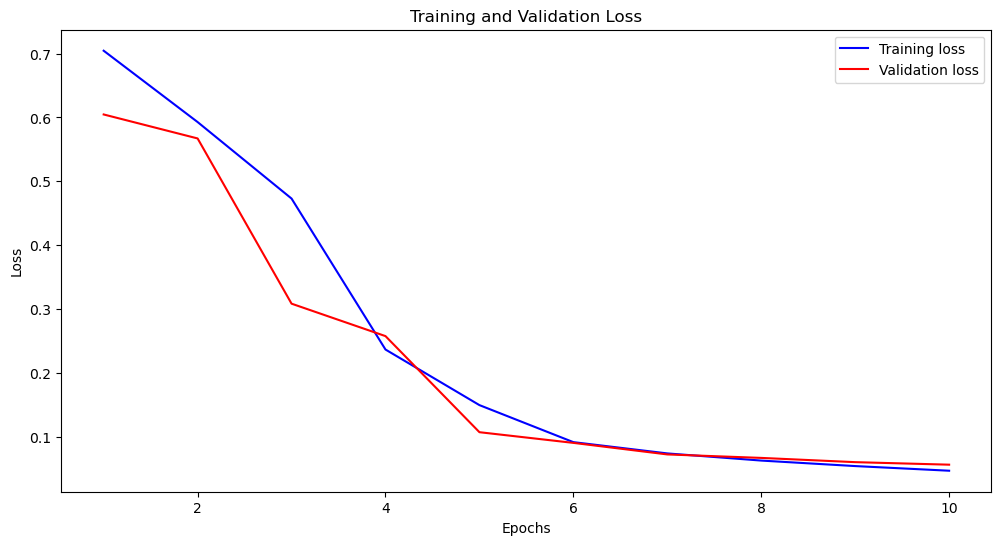

In [159]:
plot_history(history)

# As shown above, we have successfully trained a model that got 99% accuracy, and right now it is only trained on 0.1% of the dataset. 

# Experimentation  (20 points). Experiment with different aspects of the model: the number of LSTM layers, the number of fully connected layers, the size of the hidden layer, etc. Train the corresponding models, compare their performance, and provide plots to demonstrate the effect of at least two different hyperparameters of interest.


### Below, I make a new model we can use for tuning purposes

In [161]:
class LSTM_Tune(nn.Module):
    #This is our LSTM with 1 later followed by an output layer
    #This classifies a fixed-length (100 length) sequence of characters as English or Spanish
    def __init__(self, num_embeddings, embedding_dim, hidden_dim, dropout=0.5, num_lstm_layers = 1, num_fc_layers = 1):
        super(LSTM_1Layer, self).__init__()
        #We follow the structure of lecture's LSTM here
        
        
        #https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
        #Embedding layer as described in lecture
        self.emb = nn.Embedding(num_embeddings = num_embeddings, #This is the length of our dictionary
                           embedding_dim = embedding_dim) #Size of embedding vector (our choice)
        
        #https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        #LSTM has following Form:
        #nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.lstm = nn.LSTM(embedding_dim, #The input is the output of the embedding
                            hidden_dim, #Hidden dimension parameter to change
                            num_layers, # Variable number of layers
                            #batch_first=True, #interesting param, breaks everything
                            dropout=dropout) #Dropout probability
        
        
        
        # Adding variable number of FC layers
        self.fcs = nn.ModuleList()
        for _ in range(num_fc_layers - 1):
            self.fcs.append(nn.Linear(hidden_dim, hidden_dim))
        
        
        
        self.out = nn.Linear(hidden_dim, 1) #Takes in hidden_dim, doesn't use sigmoid? output is 1 dimensional
        
    def forward(self, inp, state_in):  #inp is batch x seq. state_in is (h_n, c_n)
        #Following the structure given in lecture
        embeds = self.emb(inp) #embeds is batch x seq x emb_dim
        embeds_swapped = embeds.permute(1,0,2) #seq x batch x batch_dim
        lstm_out, state_out = self.lstm(embeds_swapped, state_in) #lstm_out is seq x batch x hidden
        #state_out is (h_n, c_n)
        scores = self.out(lstm_out) #scores is seq x batch x numclasses
        scores_swapped = scores.permute(1, 0,2) #batch x seq x numclasses
        return scores_swapped, state_out #
        
        
        #no sigmoid?


In [163]:
#Here is the code where we will test out a lot of different model architectures

#Dataset Parameters
dataset_proportion = 0.001
val_split = 0.3
batch_size = 1024
num_workers = 0
train_loader, val_loader = get_train_val_loaders(dataset_proportion, val_split, batch_size, num_workers)

#Training Parameters
learning_rate = 0.02
L2 = 0#0.0001
num_epochs = 5 #Set to small number of epochs cuz this is gonna take a LONG time
momentum1 = 0.9
momentum2 = 0.999
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"My device is {device}")


#Now we cycle through many different models and add their results to the results list
lstm_layers = [1, 2, 3]
hidden_sizes = [64, 128, 256]
fc_layers = [1, 2, 3]
results = []

for n_lstm in lstm_layers:
    for hidden_dim in hidden_sizes:
        for n_fc in fc_layers:
            #Construct the model we are testing
            model = LSTM_Tune(num_embeddings = num_embeddings,
                                     embedding_dim = embedding_dim,
                                     hidden_dim = hidden_dim,
                                     dropout = dropout, 
                                     num_lstm_layers = n_lstm, 
                                     num_fc_layers = n_fc)
            
            #Train the model
            trained_model, history, final_val_accuracy = better_finetune(model,
                                                                         train_loader,
                                                                         validation_loader,
                                                                         learning_rate=learning_rate,
                                                                         num_epochs=num_epochs,
                                                                         L2=L2,
                                                                         momentum1=momentum1,
                                                                         momentum2=momentum2,
                                                                         device = device)

            
            
            #add the results
            results.append({
                'n_lstm': n_lstm,
                'hidden_dim': hidden_dim,
                'n_fc': n_fc,
                'final_val_accuracy': final_val_accuracy
            })


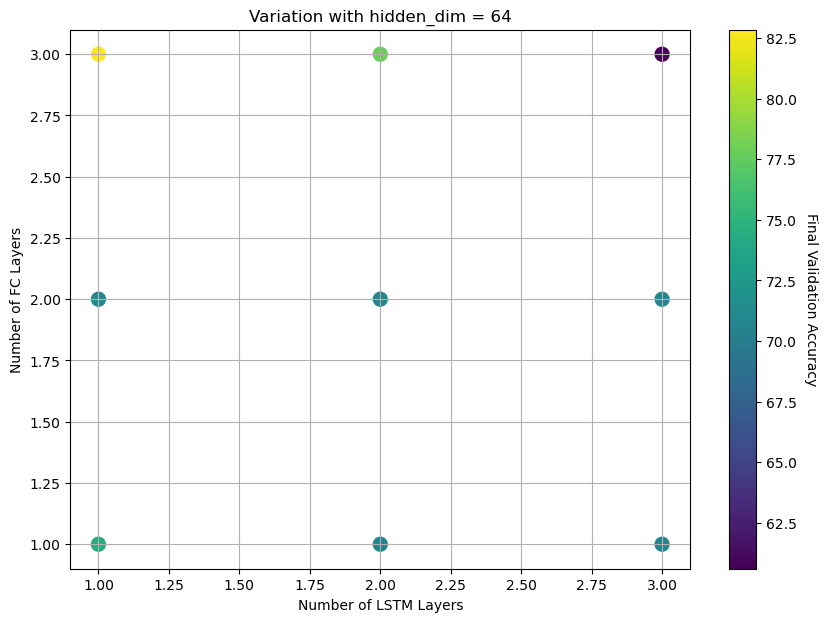

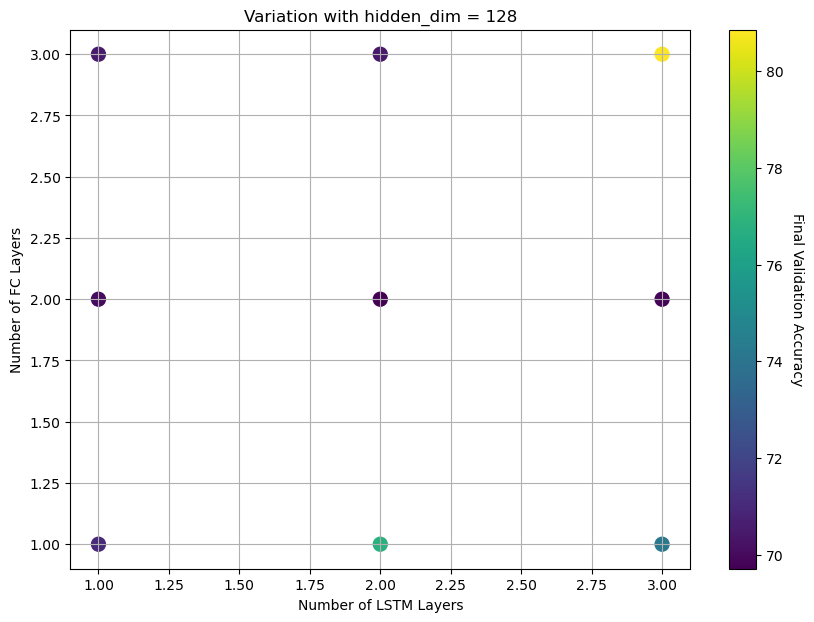

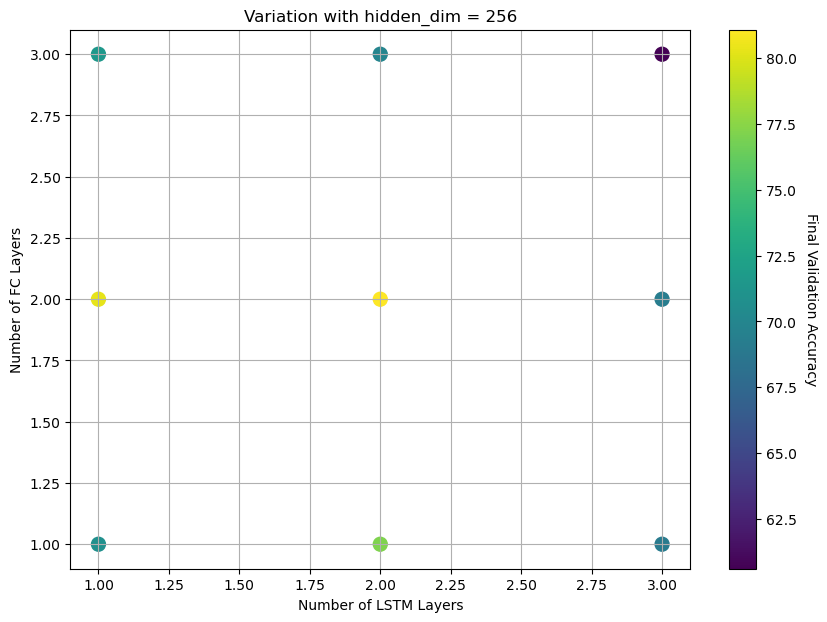

In [59]:

# Function to plot the variation of two hyperparameters against final validation accuracy

#There is probably a MUCH better way to view the results

#Feel free to make different graphs
def plot_hyperparameters_vs_accuracy(results, fixed_param, fixed_value):
    filtered_results = [r for r in results if r[fixed_param] == fixed_value]

    if fixed_param == 'hidden_dim':
        x = [r['n_lstm'] for r in filtered_results]
        y = [r['n_fc'] for r in filtered_results]
        z = [r['final_val_accuracy'] for r in filtered_results]
        xlabel = 'Number of LSTM Layers'
        ylabel = 'Number of FC Layers'
    elif fixed_param == 'n_lstm':
        x = [r['hidden_dim'] for r in filtered_results]
        y = [r['n_fc'] for r in filtered_results]
        z = [r['final_val_accuracy'] for r in filtered_results]
        xlabel = 'Hidden Dimension'
        ylabel = 'Number of FC Layers'
    else:  # fixed_param == 'n_fc'
        x = [r['n_lstm'] for r in filtered_results]
        y = [r['hidden_dim'] for r in filtered_results]
        z = [r['final_val_accuracy'] for r in filtered_results]
        xlabel = 'Number of LSTM Layers'
        ylabel = 'Hidden Dimension'

    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, c=z, cmap='viridis', s=100)
    plt.colorbar().set_label('Final Validation Accuracy', rotation=270, labelpad=15)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f'Variation with {fixed_param} = {fixed_value}')
    plt.grid(True)
    plt.show()


plot_hyperparameters_vs_accuracy(results, 'hidden_dim', 64)
plot_hyperparameters_vs_accuracy(results, 'hidden_dim', 128)
plot_hyperparameters_vs_accuracy(results, 'hidden_dim', 256)

# As shown by this section, the best architecture we found was (doesn't matter all that much, we already have a pretty good model - we just need to show that we experimented with stuff))

# Intuition (5 points). Show the output of your model for several specific sentences. Pick inputs that demonstrate the behavior of the system, and try to figure out what things the model is focusing on. Explain your intuition about what the model is doing.

### Below, we build a good model so we can experiment with it and build intuition. 

In [177]:
#Dataset Parameters
dataset_proportion = 0.001
val_split = 0.3
batch_size = 1024
num_workers = 0
train_loader, val_loader = get_train_val_loaders(dataset_proportion, val_split, batch_size, num_workers)



#Model Parameters
num_embeddings = len(unique_character_map) #for embedding layer
embedding_dim = 64 #I choose this - dimension for embedding layer
hidden_dim = 128 #Parameter - hidden dimensions
dropout = 0.5
model = LSTM_1Layer(num_embeddings = num_embeddings,
                 embedding_dim = embedding_dim,
                 hidden_dim = hidden_dim,
                 dropout = dropout)

#Training Parameters
learning_rate = 0.02
L2 = 0#0.0001
num_epochs = 10
momentum1 = 0.9
momentum2 = 0.999
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"My device is {device}")
best_trained_model, history, final_val_accuracy = better_finetune(model,
                                                             train_loader,
                                                             validation_loader,
                                                             learning_rate=learning_rate,
                                                             num_epochs=num_epochs,
                                                             L2=L2,
                                                             momentum1=momentum1,
                                                             momentum2=momentum2,
                                                             device = device)


Reading the files.


Validation: 100%|██████████████████████████████████████████████████████████████| 3008/3008 [00:00<00:00, 107750.16it/s]


My device is cpu


Training Epoch:  10%|██████▋                                                            | 1/10 [00:10<01:38, 10.94s/it]

Epoch [1/10], Training Loss: 0.7446, Validation Loss: 0.6259, Validation Accuracy: 65.99%


Training Epoch:  20%|█████████████▍                                                     | 2/10 [00:22<01:28, 11.06s/it]

Epoch [2/10], Training Loss: 0.6056, Validation Loss: 0.5574, Validation Accuracy: 69.91%


Training Epoch:  30%|████████████████████                                               | 3/10 [00:34<01:20, 11.45s/it]

Epoch [3/10], Training Loss: 0.5234, Validation Loss: 0.4385, Validation Accuracy: 85.57%


Training Epoch:  40%|██████████████████████████▊                                        | 4/10 [00:46<01:11, 11.85s/it]

Epoch [4/10], Training Loss: 0.2736, Validation Loss: 0.1396, Validation Accuracy: 96.84%


Training Epoch:  50%|█████████████████████████████████▌                                 | 5/10 [00:59<01:01, 12.24s/it]

Epoch [5/10], Training Loss: 0.1189, Validation Loss: 0.1115, Validation Accuracy: 97.07%


Training Epoch:  60%|████████████████████████████████████████▏                          | 6/10 [01:12<00:49, 12.46s/it]

Epoch [6/10], Training Loss: 0.0709, Validation Loss: 0.0784, Validation Accuracy: 98.01%


Training Epoch:  70%|██████████████████████████████████████████████▉                    | 7/10 [01:25<00:37, 12.56s/it]

Epoch [7/10], Training Loss: 0.0503, Validation Loss: 0.0637, Validation Accuracy: 98.20%


Training Epoch:  80%|█████████████████████████████████████████████████████▌             | 8/10 [01:37<00:25, 12.63s/it]

Epoch [8/10], Training Loss: 0.0396, Validation Loss: 0.0572, Validation Accuracy: 98.40%


Training Epoch:  90%|████████████████████████████████████████████████████████████▎      | 9/10 [01:50<00:12, 12.71s/it]

Epoch [9/10], Training Loss: 0.0342, Validation Loss: 0.0575, Validation Accuracy: 98.40%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████| 10/10 [02:03<00:00, 12.36s/it]

Epoch [10/10], Training Loss: 0.0307, Validation Loss: 0.0567, Validation Accuracy: 98.37%


# Below, we build a predict() function and then experiment with what the model outputs for example sentences to gain intuition of what the model is doing

In [179]:
# def predict(model, sentence, character_map):
#     # Convert sentence to tensor input
#     tensor_input = [character_map[char] for char in sentence]
#     tensor_input = torch.tensor(tensor_input).unsqueeze(0)
    
#     # Model prediction
#     model.eval()
#     with torch.no_grad():
#         output = model(tensor_input)
#     return output.item()


def predict(model, sentence, character_map):
    # Convert sentence to tensor input
    tensor_input = convert_sentence_to_fixed_length(sentence) #THIS FUNCTION ALSO WORKS IF WE JUST CONVERT THE 
    #SENTENCE TO THE CHARACTER_MAP - SUPER WEIRD!!!
    #character_map = {char: idx for idx, char in enumerate(unique_character_map)}
    #tensor_input = [character_map[char] for char in sentence] - THIS FUNCTION WORKS IF WE JUST DO THIS, SO 
    #IT ALREADY SUPPORTS VARIABLE LENGTH SENTENCES?!?!?
    tensor_input = torch.tensor(tensor_input).unsqueeze(0)  # Add batch dimension
    
    # Initial hidden and cell states (set to zeros)
    h0 = torch.zeros(1, tensor_input.size(0), model.lstm.hidden_size)  # 1 for one layer LSTM
    c0 = torch.zeros(1, tensor_input.size(0), model.lstm.hidden_size)
    
    # Model prediction
    model.eval()
    with torch.no_grad():
        scores, _ = model(tensor_input, (h0, c0))
    
    # Extract the relevant score (last sequence item for the current setup)
    # Squeezing to get a single scalar value from the tensor
    return scores[0, -1, 0].item()




#Sentences to explore
sentences = [
    "the",
    "the .",
    "the weather is super nice today",
    "que",
    "que .",
    "que the",
    "que the .",
    "the que",
    "que es la biblioteca"
]

# Predict and display the outputs for the sentences
for sentence in sentences:
    prediction = predict(best_trained_model, sentence, character_map)
    print(f"Sentence: {sentence}")
    print(f"Model Output: {prediction:.4f}\n")


#as a note, negative values are English, Positive are Spanish
#experiment with accented spanish characters for sure

#for some reason it makes predictions off of periods a lot?

Sentence: the
Model Output: -3.1472

Sentence: the .
Model Output: -3.8743

Sentence: the weather is super nice today
Model Output: -2.9864

Sentence: que
Model Output: 3.8142

Sentence: que .
Model Output: 0.5490

Sentence: que the
Model Output: -0.8659

Sentence: que the .
Model Output: -2.9401

Sentence: the que
Model Output: -2.4263

Sentence: que es la biblioteca
Model Output: 5.3264



## Part 2: Realistic system with variable-length inputs (25 points

In the second part of the assignment you will do the following:


● Prepare the data (10 points). Your data should be the same as in part 1, except that 
each sample should contain one complete sentence rather than a fixed-length sequence of characters. This means that your training & validation samples should have variable 
length. You will need to zero-pad your inputs.


● Train model (15 points). Use the best model architecture that you found from part 1, 
and train a model on your data. Be careful to handle the zero-padding correctly, since 
you can no longer use the same index for all batch samples. Show the training & 
validation loss curves and validation accuracy. Compare your results to the 
corresponding model in part 1.




### This section shouldn't be too difficult. We just need to redo the "convert_sentence_to_fixed_length" function so that we have variable length, and then the functions after that one should be very, very similar EXCEPT for that, when we build our model, we need to zero-pad stuff, which shoulnd't be too bad. The training should be very similar as well. I tested it out with sentence's that weren't all 100 characters long, and it seemed to work fine..... so idk if we even need to change anything. Try copy-pasting everything down here and see if things just work if we don't pad everything to 100 characters in the "convert_sentence_to_fixed_length" function - like rename it to "convert_sentences_unfixed_length" and make a small change to that function's logic

Running List of Resources Used: 


https://stackoverflow.com/questions/20935151/how-to-encode-and-decode-from-spanish-in-python

https://datagy.io/python-remove-punctuation-from-string/"

https://stackoverflow.com/questions/2081836/how-to-read-specific-lines-from-a-file-by-line-number

https://docs.python.org/3/library/string.html

https://blog.salesforceairesearch.com/the-wikitext-long-term-dependency-language-modeling-dataset/#download

https://stackoverflow.com/questions/36303919/what-encoding-does-open-use-by-default

https://stackoverflow.com/questions/53628622/loss-function-its-inputs-for-binary-classification-pytorch

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

https://pytorch.org/tutorials/recipes/recipes/loading_data_recipe.html

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?ref=mlnuggets.digitalpress.blog

https://stackoverflow.com/questions/59520620/creating-lstm-model-with-pytorch

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_lstm_neuralnetwork/

https://stackoverflow.com/questions/59520620/creating-lstm-model-with-pytorch

https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html